In [ ]:
#@title License
# Copyright 2018 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""A basic MNIST example using JAX with the mini-libraries stax and optimizers.

The mini-library jax.example_libraries.stax is for neural network building, and
the mini-library jax.example_libraries.optimizers is for first-order stochastic
optimization.
"""

'A basic MNIST example using JAX with the mini-libraries stax and optimizers.\n\nThe mini-library jax.example_libraries.stax is for neural network building, and\nthe mini-library jax.example_libraries.optimizers is for first-order stochastic\noptimization.\n'

In [123]:
#@title Imports
import time
import itertools

import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from google.colab import files


## Hyperparameters
Let's get a few bookkeeping items out of the way.

In [124]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
  w_key, b_key = random.split(key)
  return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key):
  keys = random.split(key, len(sizes))
  return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

layer_sizes = [784,100,100,10] #[784, 512, 512, 10]
step_size = 0.01
num_epochs = 8
batch_size = 128
n_targets = 10
params = init_network_params(layer_sizes, random.PRNGKey(0))

## Auto-batching predictions

Let us first define our prediction function. Note that we're defining this for a _single_ image example. We're going to use JAX's `vmap` function to automatically handle mini-batches, with no performance penalty.

In [125]:
from jax.scipy.special import logsumexp

def relu(x):
  return jnp.maximum(0, x)

def predict(params, image):
  # per-example predictions
  activations = image
  for w, b in params[:-1]:
    outputs = jnp.dot(w, activations) + b
    activations = relu(outputs)
  
  final_w, final_b = params[-1]
  logits = jnp.dot(final_w, activations) + final_b
  return logits - logsumexp(logits)

Let's check that our prediction function only works on single images.

In [126]:
# This works on single examples
random_flattened_image = random.normal(random.PRNGKey(1), (28 * 28,))
preds = predict(params, random_flattened_image)
print(preds.shape)

(10,)


In [127]:
# Doesn't work with a batch
random_flattened_images = random.normal(random.PRNGKey(1), (10, 28 * 28))
try:
  preds = predict(params, random_flattened_images)
except TypeError:
  print('Invalid shapes!')

Invalid shapes!


In [128]:
# Let's upgrade it to handle batches using `vmap`

# Make a batched version of the `predict` function
batched_predict = vmap(predict, in_axes=(None, 0))

# `batched_predict` has the same call signature as `predict`
batched_preds = batched_predict(params, random_flattened_images)
print(batched_preds.shape)

(10, 10)


At this point, we have all the ingredients we need to define our neural network and train it. We've built an auto-batched version of `predict`, which we should be able to use in a loss function. We should be able to use `grad` to take the derivative of the loss with respect to the neural network parameters. Last, we should be able to use `jit` to speed up everything.

## Utility and loss functions

In [139]:
def one_hot(x, k, dtype=jnp.float32):
  """Create a one-hot encoding of x of size k."""
  return jnp.array(x[:, None] == jnp.arange(k), dtype)
  
def accuracy(params, images, targets):
  target_class = jnp.argmax(targets, axis=1)
  predicted_class = jnp.argmax(batched_predict(params, images), axis=1)
  return jnp.mean(predicted_class == target_class)

def loss(params, images, targets):
  preds = batched_predict(params, images)
  return -jnp.mean(preds * targets)

@jit
def update(params, x, y):
  grads = grad(loss)(params, x, y)
  return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grads)]

## Data Loading with PyTorch

JAX is laser-focused on program transformations and accelerator-backed NumPy, so we don't include data loading or munging in the JAX library. There are already a lot of great data loaders out there, so let's just use them instead of reinventing anything. We'll grab PyTorch's data loader, and make a tiny shim to make it work with NumPy arrays.

In [130]:
!pip install torch torchvision

In [131]:
import numpy as np
from torch.utils import data
from torchvision.datasets import MNIST

def numpy_collate(batch):
  if isinstance(batch[0], np.ndarray):
    return np.stack(batch)
  elif isinstance(batch[0], (tuple,list)):
    transposed = zip(*batch)
    return [numpy_collate(samples) for samples in transposed]
  else:
    return np.array(batch)

class NumpyLoader(data.DataLoader):
  def __init__(self, dataset, batch_size=1,
                shuffle=False, sampler=None,
                batch_sampler=None, num_workers=0,
                pin_memory=False, drop_last=False,
                timeout=0, worker_init_fn=None):
    super(self.__class__, self).__init__(dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        sampler=sampler,
        batch_sampler=batch_sampler,
        num_workers=num_workers,
        collate_fn=numpy_collate,
        pin_memory=pin_memory,
        drop_last=drop_last,
        timeout=timeout,
        worker_init_fn=worker_init_fn)

class FlattenAndCast(object):
  def __call__(self, pic):
    return np.ravel(np.array(pic, dtype=jnp.float32))

In [132]:
# Define our dataset, using torch datasets
mnist_dataset = MNIST('/tmp/mnist/', download=True, transform=FlattenAndCast())
training_generator = NumpyLoader(mnist_dataset, batch_size=batch_size, num_workers=0)

In [133]:
# Get the full train dataset (for checking accuracy while training)
train_images = np.array(mnist_dataset.train_data).reshape(len(mnist_dataset.train_data), -1)
train_labels = one_hot(np.array(mnist_dataset.train_labels), n_targets)

# Get full test dataset
mnist_dataset_test = MNIST('/tmp/mnist/', download=True, train=False)
test_images = jnp.array(mnist_dataset_test.test_data.numpy().reshape(len(mnist_dataset_test.test_data), -1), dtype=jnp.float32)
test_labels = one_hot(np.array(mnist_dataset_test.test_labels), n_targets)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


## Training Loop

In [141]:
def get_sizes(l):
  return [[x.shape for x in y] for y in l]

In [142]:
def get_flat(grads):
  return jnp.concatenate([jnp.concatenate([x[0].flatten(), x[1].flatten()]) for x in grads])

def get_hvp(f, params, v, x, y):
  return grad(lambda params: jnp.vdot(get_flat(grad(f)(params, x, y)), v))(params)

In [122]:
print(get_sizes(params))
grads = grad(loss)(params, x, y)
print(get_sizes(grads))
flat_grad = get_flat(grads)
print(flat_grad.shape)
flat_v = np.random.rand(*flat_grad.shape)
print(v.shape)

[[(3,), (1,)]]
[[(3,), (1,)]]
(4,)
(4,)


In [147]:
def power_alg(hvp_fn, flat_v, iters=10):
  hvp_v = hvp_fn(flat_v)
  flat_hvp_v = get_flat(hvp_v)
  if iters == 0:
    return jnp.dot(flat_v, flat_hvp_v)
  normed_hvp_v = flat_hvp_v/jnp.linalg.norm(flat_hvp_v)
  return power_alg(hvp_fn, normed_hvp_v, iters=iters-1)

hvp_fn = lambda v: get_hvp(loss, params, flat_v, x, y)
eig1 = power_alg(hvp_fn, v, iters=10)

In [206]:
num_epochs = 20

In [215]:
foo = []
for x in log:
  x['train'] = float(x['train'])
  x['test'] = float(x['test'])
  foo.append(x)
log = foo

In [208]:
import time

log = []
for epoch in range(num_epochs):
  start_time = time.time()
  for i, (x, y) in enumerate(training_generator):
    y = one_hot(y, n_targets)
    params = update(params, x, y)

    if i % 25 == 0:
      flat_params = get_flat(params)
      flat_v = np.random.rand(*flat_params.shape)
      hvp = get_hvp(loss, params, flat_v, x, y)
      hvp_fn = lambda v: get_hvp(loss, params, flat_v, x, y)
      eig1 = power_alg(hvp_fn, v, iters=20)

      train_acc = accuracy(params, train_images, train_labels)
      test_acc = accuracy(params, test_images, test_labels)
      log.append({'step': i, 'epoch': epoch, 'eig1': float(eig1),
                 'train': float(train_acc),
                 'test': float(test_acc),}
                 )

    # H = get_hessian(loss)(params, x, y)
  epoch_time = time.time() - start_time

  train_acc = accuracy(params, train_images, train_labels)
  test_acc = accuracy(params, test_images, test_labels)
  print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
  print("Training set accuracy {}".format(train_acc))
  print("Test set accuracy {}".format(test_acc))
  print('Eig1: ', eig1)

  

Epoch 0 in 28.11 sec
Training set accuracy 0.9855833649635315
Test set accuracy 0.973099946975708
Eig1:  288.65112
Epoch 1 in 27.39 sec
Training set accuracy 0.98621666431427
Test set accuracy 0.9729999899864197
Eig1:  279.78198
Epoch 2 in 28.06 sec
Training set accuracy 0.9868666529655457
Test set accuracy 0.973099946975708
Eig1:  291.2206
Epoch 3 in 28.56 sec
Training set accuracy 0.9873999953269958
Test set accuracy 0.973800003528595
Eig1:  283.8095
Epoch 4 in 27.13 sec
Training set accuracy 0.9879833459854126
Test set accuracy 0.9741999506950378
Eig1:  287.6483
Epoch 5 in 27.33 sec
Training set accuracy 0.9884166717529297
Test set accuracy 0.9745000004768372
Eig1:  282.54153
Epoch 6 in 27.18 sec
Training set accuracy 0.9888666868209839
Test set accuracy 0.97489994764328
Eig1:  264.8455
Epoch 7 in 26.85 sec
Training set accuracy 0.9894333481788635
Test set accuracy 0.9751999974250793
Eig1:  287.7535
Epoch 8 in 27.28 sec
Training set accuracy 0.9897000193595886
Test set accuracy 0.97

In [216]:
df = pd.DataFrame(log)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

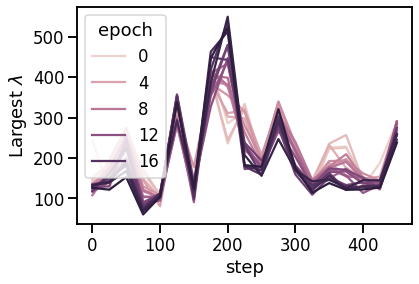

In [228]:
sns.set_context(context='talk')
f = plt.figure()
sns.lineplot(data=df, x='step', y='eig1', hue='epoch', markers=True)
plt.ylabel('Largest $\lambda$')

figname = "largest_lambda_mnist.pdf"
f.savefig(figname, bbox_inches='tight')
files.download(figname) 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

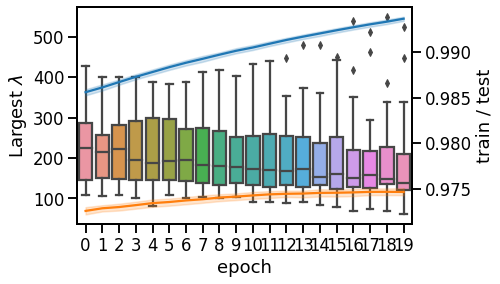

In [229]:
sns.boxplot(data=df, x='epoch', y='eig1')
plt.ylabel('Largest $\lambda$')
ax2 = plt.twinx()
sns.lineplot(data=df, x='epoch', y='train', palette=sns.color_palette("Blues", as_cmap=True), ax=ax2)
sns.lineplot(data=df, x='epoch', y='test', palette=sns.color_palette("Greens", as_cmap=True), ax=ax2)
plt.ylabel('train / test')

figname = "largest-lambda_mnist_epoch_vs_eig1.pdf"
f.savefig(figname, bbox_inches='tight')
files.download(figname) 



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Simpler application

In [ ]:
from jax import jacfwd, jacrev


In [65]:
W = jnp.array([1, 1])
b = jnp.array([3, 3])


In [67]:
key = random.PRNGKey(0)

In [87]:
# Outputs probability of a label being true.
def predict(W, b, inputs):
    return jnp.dot(inputs, W) + b

# Build a toy dataset.
inputs = jnp.array([[0.52, 1.12,  0.77],
                   [0.88, -1.08, 0.15],
                   [0.52, 0.06, -1.30],
                   [0.74, -2.49, 1.39]])
targets = jnp.array([True, True, False, True])

# Training loss is the negative log-likelihood of the training examples.
def loss(params, inputs, targets):
  for W, b in params: # assumes 1 layer
    preds = predict(W, b, inputs)
  label_probs = preds * targets + (1 - preds) * (1 - targets)
  return -jnp.sum(jnp.log(label_probs))

# Initialize random model coefficients
key, W_key, b_key = random.split(key, 3)
W = random.normal(W_key, (3,))
b = random.normal(b_key, (1,))

def get_params(W, b):
  return [[W, b]]

params = get_params(W, b)

In [107]:
def get_flat(grads):
  return jnp.concatenate([jnp.concatenate([x[0].flatten(), x[1].flatten()]) for x in grads])

def get_hvp(f, params, v, x, y):
  return grad(lambda params: jnp.vdot(get_flat(grad(f)(params, x, y)), v))(params)

In [111]:
print(get_sizes(params))
grads = grad(loss)(params, inputs, targets)
print(get_sizes(grads))
flat_grad = get_flat(grads)
print(flat_grad.shape)
flat_v = np.random.rand(*flat_grad.shape)
print(v.shape)

[[(3,), (1,)]]
[[(3,), (1,)]]
(4,)
(4,)


In [93]:
hvp = get_hvp(loss, params, v, inputs, targets)

In [113]:
def power_alg(hvp_fn, flat_v, iters=10):
  hvp_v = hvp_fn(flat_v)
  flat_hvp_v = get_flat(hvp_v)
  if iters == 0:
    return jnp.dot(flat_v, flat_hvp_v)
  normed_hvp_v = flat_hvp_v/jnp.linalg.norm(flat_hvp_v)
  return power_alg(hvp_fn, normed_hvp_v, iters=iters-1)

hvp_fn = lambda v: get_hvp(loss, params, flat_v, inputs, targets)
eig1 = power_alg(hvp_fn, v, iters=10)

In [114]:
eig1

DeviceArray(26.773132, dtype=float32)